In [217]:
import pandas as pd
import numpy as np
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import os
import matplotlib.pyplot as plt


In [218]:
# Prototype option:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # Set a fallback to CPU if MPS is not yet implemented

# Assign cuda to the device to use for training
if torch.cuda.is_available(): 
 dev = "cuda:0" 
 print("This model will run on CUDA")
# elif  torch.backends.mps.is_available(): 
#  dev = "mps:0"
#  print("This model will run on MPS")
else:
 dev = "cpu" 
 print("This model will run on CPU")
device = torch.device(dev) 

This model will run on CPU


In [219]:
# Load the desired model and tokenizer
model_name = "80K"
output_dir = f"../7. Models/{model_name}/"
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)

In [220]:
# Load the validation dataset
val_file = f'./../3. Cleaned Data/{model_name}_val.csv'
val_df = pd.read_csv(val_file)

# During initial testing, will only choose 50 for speed
val_df = val_df.sample(50, random_state=123).reset_index()

In [221]:
# Function to generate predictions using the model
def generate_prediction(prompt, max_length=100, temperature=1.0, top_p=1.0):
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=device)
    with torch.no_grad():
        output = model.generate(
            input_ids, 
            attention_mask=attention_mask, 
            max_length=max_length, 
            num_return_sequences=1, 
            no_repeat_ngram_size=2,
            temperature=temperature,
            top_p=top_p,
        )
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [222]:
# Calculate BLEU score and cosine distance
bleu_scores = []
cosine_distances = []

vectorizer = TfidfVectorizer()

In [223]:
for index, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    original = row['original']
    corrected = row['corrected']

    # Set max_length dynamically based on the length of the original text
    prompt = f"input: {original} output:"
    prompt_length = len(tokenizer.encode(prompt))
    dynamic_max_length = int(1.5 * len(original.split())) + prompt_length
    print(dynamic_max_length)

    # Generate prediction
    prediction = generate_prediction(prompt, max_length=dynamic_max_length, temperature=0.8, top_p=0.8)

    # Extract the actual generated output
    generated_output = prediction.split("output:")[1].strip()

    # Save the generated output
    val_df.loc[index, 'predicted'] = generated_output

    # Calculate BLEU score
    bleu_score = sentence_bleu([corrected.split()], generated_output.split(), weights=(0.33, 0.33, 0.33))

    # Save the BLEU score
    val_df.loc[index, 'BLEU'] = bleu_score

    # Calculate cosine distance
    vector_matrix = vectorizer.fit_transform([corrected, generated_output])
    cosine_distance = cosine_similarity(vector_matrix[0:1], vector_matrix[1:2])[0][0]

    # Save the cosine distance
    val_df.loc[index, 'cosine'] = cosine_distance


  0%|          | 0/50 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


20


/Users/stefanhall/opt/anaconda3/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/stefanhall/opt/anaconda3/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  2%|▏         | 1/50 [00:00<00:11,  4.31it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


41


/Users/stefanhall/opt/anaconda3/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  4%|▍         | 2/50 [00:00<00:19,  2.51it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


28


/Users/stefanhall/opt/anaconda3/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  6%|▌         | 3/50 [00:01<00:16,  2.81it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


28


  8%|▊         | 4/50 [00:01<00:17,  2.63it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


46


 10%|█         | 5/50 [00:01<00:19,  2.32it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


25


 12%|█▏        | 6/50 [00:02<00:16,  2.62it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


54


 14%|█▍        | 7/50 [00:02<00:19,  2.17it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


32


 18%|█▊        | 9/50 [00:03<00:13,  2.94it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


17
25


 20%|██        | 10/50 [00:03<00:12,  3.11it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


32


 24%|██▍       | 12/50 [00:04<00:10,  3.64it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


15
35


 26%|██▌       | 13/50 [00:04<00:12,  3.06it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


23


 28%|██▊       | 14/50 [00:04<00:10,  3.35it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


51


 30%|███       | 15/50 [00:05<00:13,  2.59it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


36


 32%|███▏      | 16/50 [00:05<00:13,  2.55it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


28


 34%|███▍      | 17/50 [00:06<00:11,  2.77it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


31


 36%|███▌      | 18/50 [00:06<00:11,  2.79it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


62


 38%|███▊      | 19/50 [00:07<00:14,  2.21it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


42


 42%|████▏     | 21/50 [00:07<00:10,  2.69it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


17
41


 44%|████▍     | 22/50 [00:08<00:11,  2.54it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


66


 46%|████▌     | 23/50 [00:09<00:13,  1.99it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


32


 48%|████▊     | 24/50 [00:09<00:11,  2.19it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


37


 52%|█████▏    | 26/50 [00:09<00:08,  2.76it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


19
72


 54%|█████▍    | 27/50 [00:10<00:11,  2.02it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


36


 56%|█████▌    | 28/50 [00:11<00:10,  2.19it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


59


 58%|█████▊    | 29/50 [00:11<00:11,  1.88it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


32


 60%|██████    | 30/50 [00:12<00:09,  2.15it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


29


 62%|██████▏   | 31/50 [00:12<00:07,  2.45it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


33


 64%|██████▍   | 32/50 [00:12<00:06,  2.59it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


37


 66%|██████▌   | 33/50 [00:13<00:07,  2.42it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


29


 68%|██████▊   | 34/50 [00:13<00:06,  2.61it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


102


 70%|███████   | 35/50 [00:14<00:10,  1.42it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


29


 72%|███████▏  | 36/50 [00:15<00:08,  1.74it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


25


 74%|███████▍  | 37/50 [00:15<00:06,  2.08it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


22


 76%|███████▌  | 38/50 [00:15<00:04,  2.50it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


71


 78%|███████▊  | 39/50 [00:16<00:05,  1.93it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


28


 80%|████████  | 40/50 [00:16<00:04,  2.25it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


24


 82%|████████▏ | 41/50 [00:17<00:03,  2.64it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


52


 84%|████████▍ | 42/50 [00:17<00:03,  2.32it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


47


 86%|████████▌ | 43/50 [00:18<00:03,  1.83it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


52


 88%|████████▊ | 44/50 [00:19<00:03,  1.50it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


17


 90%|█████████ | 45/50 [00:19<00:02,  1.87it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


36


 92%|█████████▏| 46/50 [00:19<00:01,  2.01it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


74


 94%|█████████▍| 47/50 [00:20<00:01,  1.74it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


44


 96%|█████████▌| 48/50 [00:21<00:01,  1.90it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


63


 98%|█████████▊| 49/50 [00:21<00:00,  1.77it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


22


100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


In [224]:
outputs = val_df[['original','corrected','predicted','BLEU','cosine']]

In [225]:
val_gen = f'./../3. Cleaned Data/{model_name}_val_gen_test.csv'
outputs.to_csv(val_gen)

In [226]:
# Calculate the average BLEU score
average_bleu = val_df['BLEU'].mean()
print(f"Average BLEU score: {average_bleu}")

# Calculate the average cosine similarity
average_cosine = val_df['cosine'].mean()
print(f"Average cosine similarity: {average_cosine}")

Average BLEU score: 0.0385893781506456
Average cosine similarity: 0.3694749207559221


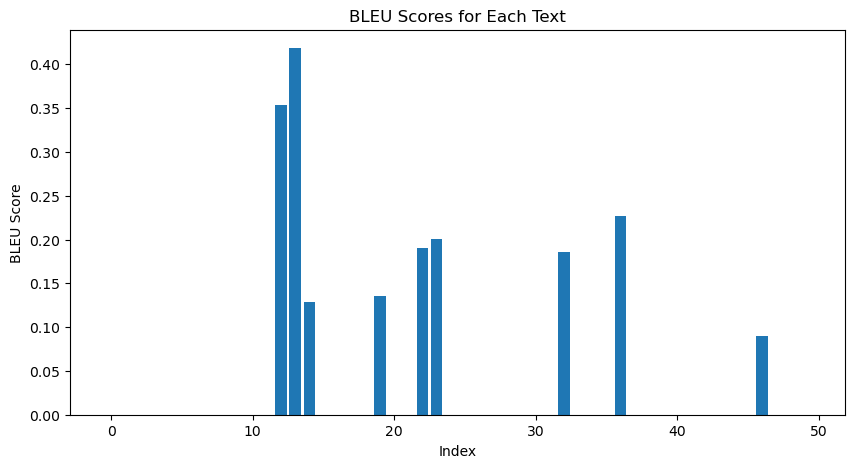

In [227]:
# Bar plot of BLEU scores
plt.figure(figsize=(10, 5))
plt.bar(val_df.index, val_df['BLEU'])
plt.xlabel('Index')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores for Each Text')
plt.show()

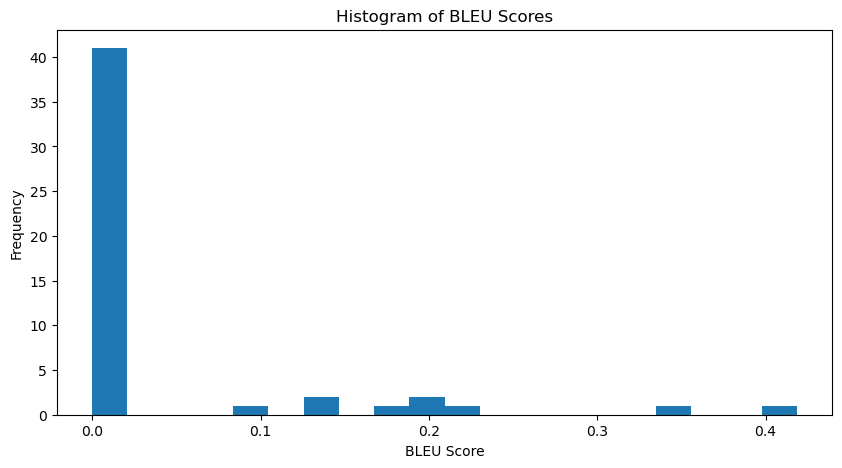

In [228]:
# Histogram of BLEU scores
plt.figure(figsize=(10, 5))
plt.hist(val_df['BLEU'], bins=20)
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('Histogram of BLEU Scores')
plt.show()

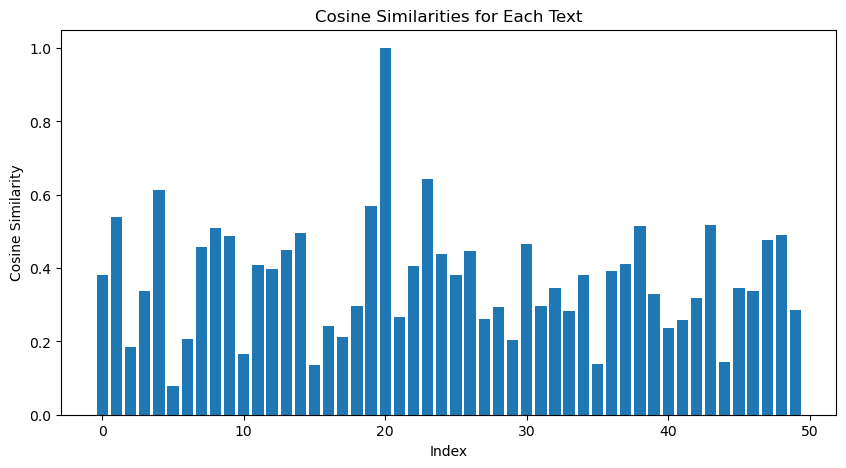

In [229]:

# Bar plot of cosine similarities
plt.figure(figsize=(10, 5))
plt.bar(val_df.index, val_df['cosine'])
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarities for Each Text')
plt.show()

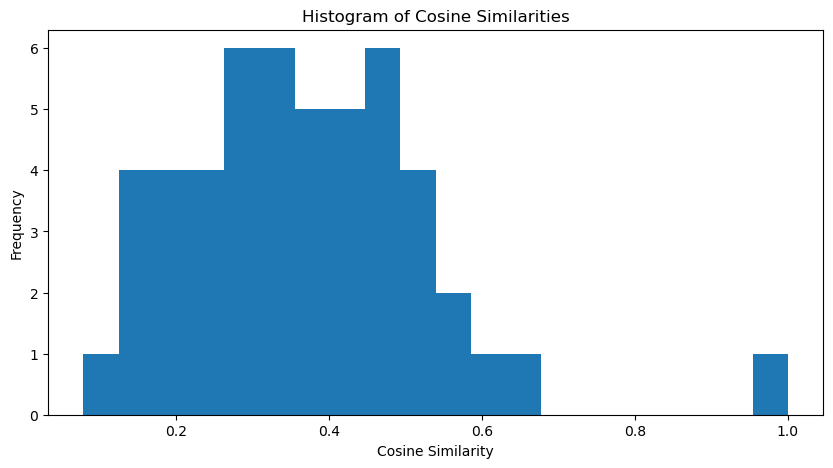

In [230]:
# Histogram of cosine similarities
plt.figure(figsize=(10, 5))
plt.hist(val_df['cosine'], bins=20)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')
plt.show()